# **Elliptic++ Actors (Wallet Addresses) Dataset**

***Note: "Actor" refers to a Bitcoin wallet address***

---
---


Released by: Youssef Elmougy, Ling Liu



School of Computer Science, Georgia Institute of Technology

Contact: yelmougy3@gatech.edu


---

Github Repository: [https://www.github.com/git-disl/EllipticPlusPlus](https://www.github.com/git-disl/EllipticPlusPlus)


If you use our dataset in your work, please cite our paper:





>> Youssef Elmougy and Ling Liu. 2023. Demystifying Fraudulent Transactions and Illicit Nodes in the Bitcoin Network for Financial Forensics.

---



## [SETUP] Import libraries and csv files 

Download dataset from: [https://www.github.com/git-disl/EllipticPlusPlus](https://www.github.com/git-disl/EllipticPlusPlus)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp drive/My\ Drive/Elliptic++\ Dataset/wallets_features.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/wallets_classes.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/AddrAddr_edgelist.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/AddrTx_edgelist.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/TxAddr_edgelist.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/wallets_features_classes_combined.csv ./

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objs as go 
import plotly.offline as py 
import math
from collections import Counter

!pip install -U ipython 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone 

import xgboost as xgb

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 17.7 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=4ad64e3b8b283172c1ae01f750cdea27fcc42eeef533a5a0428c77fa474f08d2
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatib

## Actors Dataset Overview


---

This section loads the 5 csv files (wallets_features, wallets_classes, AddrAddr_edgelist, AddrTx_edgelist, TxAddr_edgelist) and provides a quick overview of the dataset structure and features.

Load saved actors dataset csv files:

In [ ]:
print("\nActors features: \n")
df_wallets_features = pd.read_csv("wallets_features.csv")
df_wallets_features

print("\nActors Classes: \n")
df_wallets_classes = pd.read_csv("wallets_classes.csv")
df_wallets_classes

print("\nAddress-Address edgelist: \n") #Actor Interaction graph edgelist
df_AddrAddr_edgelist = pd.read_csv("AddrAddr_edgelist.csv")
df_AddrAddr_edgelist

print("\nAddress-Transaction edgelist: \n") #Address-Transaction graph edgelist
df_AddrTx_edgelist = pd.read_csv("AddrTx_edgelist.csv")
df_AddrTx_edgelist

print("\nTransaction-Address edgelist: \n") #Address-Transaction graph edgelist
df_TxAddr_edgelist = pd.read_csv("TxAddr_edgelist.csv")
df_TxAddr_edgelist

# combined features and classes csv files for convenience
df_wallets_features_classes_combined = pd.read_csv("wallets_features_classes_combined.csv")


Actors features: 



address  Time step  num_txs_as_sender  \
0         111112TykSw72ztDN2WJger4cynzWYC5w         25                0.0   
1         1111DAYXhoxZx2tsRnzimfozo783x1yC2         25                0.0   
2         1111DAYXhoxZx2tsRnzimfozo783x1yC2         29                0.0   
3         1111DAYXhoxZx2tsRnzimfozo783x1yC2         39                0.0   
4         1111DAYXhoxZx2tsRnzimfozo783x1yC2         39                0.0   
...                                     ...        ...                ...   
1268255  3R2Uw5MRdSSigp8AjfT7K5es6Hupm4qLSq         31                1.0   
1268256  3R2VBFbqHGC4bQ7b4ixN4jZTdv7RMbEYtf         44                0.0   
1268257  3R2WFmRwbDeo3rMVVu5J3jjMxAuQYYWAid          9                0.0   
1268258  3R2WTZGYLmbJQyoDSBftJsPRvF1mSEtkh6          3                0.0   
1268259  3R2bm6iqbzcVpEeFCSFarS56b56QfjyiSW          9                1.0   

         num_txs_as receiver  first_block_appeared_in  last_block_appeared_in  \
0                        1.0                 439586.0                439586.0   
1                        8.0                 439589.0                485959.0   
2                        8.0                 439589.0                485959.0   
3                        8.0                 439589.0                485959.0   
4                        8.0                 439589.0                485959.0   
...                      ...                      ...                     ...   
1268255                  1.0                 451684.0                451685.0   
1268256                  1.0                 477895.0                477895.0   
1268257                  1.0                 407342.0                407342.0   
1268258                  1.0                 395235.0                395235.0   
1268259                  0.0                 407333.0                407333.0   

         lifetime_in_blocks  total_txs  first_sent_block  \
0                       0.0        1.0               0.0   
1                   46370.0        8.0               0.0   
2                   46370.0        8.0               0.0   
3                   46370.0        8.0               0.0   
4                   46370.0        8.0               0.0   
...                     ...        ...               ...   
1268255                 1.0        2.0          451685.0   
1268256                 0.0        1.0               0.0   
1268257                 0.0        1.0               0.0   
1268258                 0.0        1.0               0.0   
1268259                 0.0        1.0          407333.0   

         first_received_block  ...  blocks_btwn_output_txs_min  \
0                    439586.0  ...                         0.0   
1                    439589.0  ...                         0.0   
2                    439589.0  ...                         0.0   
3                    439589.0  ...                         0.0   
4                    439589.0  ...                         0.0   
...                       ...  ...                         ...   
1268255              451684.0  ...                         0.0   
1268256              477895.0  ...                         0.0   
1268257              407342.0  ...                         0.0   
1268258              395235.0  ...                         0.0   
1268259                   0.0  ...                         0.0   

         blocks_btwn_output_txs_max  blocks_btwn_output_txs_mean  \
0                               0.0                     0.000000   
1                           20164.0                  6624.285714   
2                           20164.0                  6624.285714   
3                           20164.0                  6624.285714   
4                           20164.0                  6624.285714   
...                             ...                          ...   
1268255                         0.0                     0.000000   
1268256                         0.0                     0.000000   
1268257     


Actors Classes: 



address  class
0        111112TykSw72ztDN2WJger4cynzWYC5w      2
1        1111DAYXhoxZx2tsRnzimfozo783x1yC2      3
2         1111VHuXEzHaRCgXbVwojtaP7Co3QABb      2
3       111218KKkh1JJFRHbwM16AwCiVCc4m7he1      3
4        1115LWW3xsD9jT9VRY7viCN9S34RVAAuA      2
...                                    ...    ...
822937  3R2Uw5MRdSSigp8AjfT7K5es6Hupm4qLSq      3
822938  3R2VBFbqHGC4bQ7b4ixN4jZTdv7RMbEYtf      3
822939  3R2WFmRwbDeo3rMVVu5J3jjMxAuQYYWAid      3
822940  3R2WTZGYLmbJQyoDSBftJsPRvF1mSEtkh6      3
822941  3R2bm6iqbzcVpEeFCSFarS56b56QfjyiSW      3

[822942 rows x 2 columns]


Address-Address edgelist: 



input_address  \
0        14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a   
1        14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a   
2        13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w   
3        1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz   
4        1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz   
...                                     ...   
2868959  3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh   
2868960  3DzbpEogZ1mn9FgCHcmzYPLDbV9GuxYHpi   
2868961  34yD1sQg6C16aANCtibYXRj5NsX6tt4v5R   
2868962  1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2   
2868963  1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2   

                             output_address  
0        1GASxu5nMntiRKdVtTVRvEbP965G51bhHH  
1        14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a  
2        1GFdrdgtG34GChM8SMpMwcXFc4nYbH1A5G  
3        19q57SeCEzTnWrWVXA43nZzhSiXkYggh7c  
4        1Kk1NVYnCE8ALXDhgMM6HqTt1jDSvi6QBA  
...                                     ...  
2868959  3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh  
2868960  38jMiiZs2C5n5MPkyc5pSA7wwW6H4p6hPa  
2868961  3G9b7hWZccuft1V4eGUcZqTZaxsqx699bM  
2868962  1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2  
2868963  15T4xJj6XxyPZWGLPR3S72hD9f9YzUQf36  

[2868964 rows x 2 columns]


Address-Transaction edgelist: 



input_address       txId
0       14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a  230325127
1       13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w  230325139
2       1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz   86875675
3       16zs5SVSyADh5WrLNbZbpRLsBsN5uEzgeK  230325147
4       1QJpwtUorBKPGUJkSyrRcBKTAHq4CXrdYh  230325154
...                                    ...        ...
477112   1HdnGvuc21Y4QfBEHUc3NFRJhGywdSFUb  157659046
477113  3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh  157659306
477114  3DzbpEogZ1mn9FgCHcmzYPLDbV9GuxYHpi  157668825
477115  34yD1sQg6C16aANCtibYXRj5NsX6tt4v5R  125788182
477116  1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2  157670868

[477117 rows x 2 columns]


Transaction-Address edgelist: 



txId                      output_address
0       230325127  1GASxu5nMntiRKdVtTVRvEbP965G51bhHH
1       230325127  14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a
2       230325139  1GFdrdgtG34GChM8SMpMwcXFc4nYbH1A5G
3        86875675  19q57SeCEzTnWrWVXA43nZzhSiXkYggh7c
4        86875675  1Kk1NVYnCE8ALXDhgMM6HqTt1jDSvi6QBA
...           ...                                 ...
837119  157659306  3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh
837120  157668825  38jMiiZs2C5n5MPkyc5pSA7wwW6H4p6hPa
837121  125788182  3G9b7hWZccuft1V4eGUcZqTZaxsqx699bM
837122  157670868  1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2
837123  157670868  15T4xJj6XxyPZWGLPR3S72hD9f9YzUQf36

[837124 rows x 2 columns]

Data structure for an example actor (address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K):

In [ ]:
print("\nwallets_features.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K\n")
df_wallets_features[df_wallets_features['address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']

print("\nwallets_classes.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K\n")
df_wallets_classes[df_wallets_classes['address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']

print("\nAddrAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0\n")
df_AddrAddr_edgelist[(df_AddrAddr_edgelist['input_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K') | (df_AddrAddr_edgelist['output_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K')]

print("\nAddrTx_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0\n")
df_AddrTx_edgelist[df_AddrTx_edgelist['input_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']

print("\nTxAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0\n")
df_TxAddr_edgelist[df_TxAddr_edgelist['output_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']


wallets_features.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



address  Time step  num_txs_as_sender  \
1149250  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K         23              420.0   
1149251  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K         23              420.0   
1149252  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K         23              420.0   
1149253  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K         23              420.0   
1149254  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K         24              420.0   
...                                     ...        ...                ...   
1149666  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K         32              420.0   
1149667  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K         32              420.0   
1149668  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K         32              420.0   
1149669  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K         32              420.0   
1149670  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K         32              420.0   

         num_txs_as receiver  first_block_appeared_in  last_block_appeared_in  \
1149250                  1.0                 435559.0                453704.0   
1149251                  1.0                 435559.0                453704.0   
1149252                  1.0                 435559.0                453704.0   
1149253                  1.0                 435559.0                453704.0   
1149254                  1.0                 435559.0                453704.0   
...                      ...                      ...                     ...   
1149666                  1.0                 435559.0                453704.0   
1149667                  1.0                 435559.0                453704.0   
1149668                  1.0                 435559.0                453704.0   
1149669                  1.0                 435559.0                453704.0   
1149670                  1.0                 435559.0                453704.0   

         lifetime_in_blocks  total_txs  first_sent_block  \
1149250             18145.0      421.0          435559.0   
1149251             18145.0      421.0          435559.0   
1149252             18145.0      421.0          435559.0   
1149253             18145.0      421.0          435559.0   
1149254             18145.0      421.0          435559.0   
...                     ...        ...               ...   
1149666             18145.0      421.0          435559.0   
1149667             18145.0      421.0          435559.0   
1149668             18145.0      421.0          435559.0   
1149669             18145.0      421.0          435559.0   
1149670             18145.0      421.0          435559.0   

         first_received_block  ...  blocks_btwn_output_txs_min  \
1149250              451682.0  ...                         0.0   
1149251              451682.0  ...                         0.0   
1149252              451682.0  ...                         0.0   
1149253              451682.0  ...                         0.0   
1149254              451682.0  ...                         0.0   
...                       ...  ...                         ...   
1149666              451682.0  ...                         0.0   
1149667              451682.0  ...                         0.0   
1149668              451682.0  ...                         0.0   
1149669              451682.0  ...                         0.0   
1149670              451682.0  ...                         0.0   

         blocks_btwn_output_txs_max  blocks_btwn_output_txs_mean  \
1149250                         0.0                          0.0   
1149251                         0.0                          0.0   
1149252                         0.0                          0.0   
1149253                         0.0                          0.0   
1149254                         0.0                          0.0   
...                             ...                          ...   
1149666                         0.0                          0.0   
1149667                         0.0                          0.0   
1149668     


wallets_classes.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



address  class
745591  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K      1


AddrAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0



input_address  \
1317522  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K   
1317523  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K   
1317634  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K   
1317635  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K   
1317644  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K   
...                                     ...   
1592119  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K   
1592120  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K   
1592121  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K   
1592122  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K   
1592123  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K   

                             output_address  
1317522  131fHSzsK1eQJp7bC94JVWZqJ2JcdR5UfS  
1317523  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  
1317634  1FCw4XNAP6xeWMF4o3RaNENguE9qFumgpn  
1317635  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  
1317644  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  
...                                     ...  
1592119  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  
1592120  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  
1592121  32ZkfqSGoxdx5UGo8YQp1tFhSv8R982Usk  
1592122  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  
1592123  1KVqB5L93xNQ387NkNZc6rkx4p4HaWpZa9  

[915 rows x 2 columns]


AddrTx_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0



input_address       txId
235194  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  291338524
235250  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K   88250674
235255  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  331553508
235256  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  331553509
239085  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  289228146
...                                    ...        ...
298647  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  355110135
298648  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  355110139
298649  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  343635736
298650  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K  355110144
298651  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K   69064953

[420 rows x 2 columns]


TxAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0



txId                      output_address
431088  291338524  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
431200   88250674  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
431209  331553508  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
431212  331553509  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
436269  289228146  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
...           ...                                 ...
539069  355110135  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
539071  355110139  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
539073  343635736  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
539074  355110144  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
539076   69064953  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K

[421 rows x 2 columns]


Actors features --- class, 28 transaction-related features, 27 time-related features:

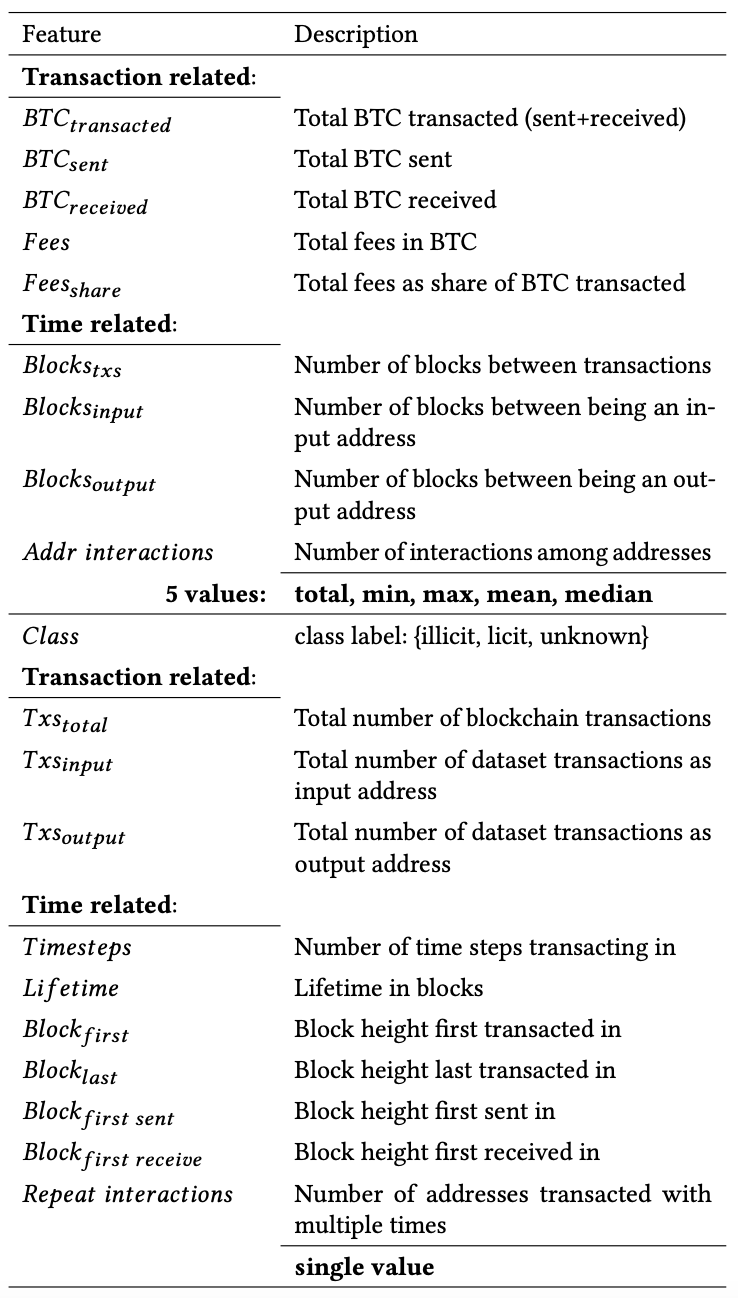


In [ ]:
df_wallets_features.columns

Index(['address', 'Time step', 'num_txs_as_sender', 'num_txs_as receiver',
       'first_block_appeared_in', 'last_block_appeared_in',
       'lifetime_in_blocks', 'total_txs', 'first_sent_block',
       'first_received_block', 'num_timesteps_appeared_in',
       'btc_transacted_total', 'btc_transacted_min', 'btc_transacted_max',
       'btc_transacted_mean', 'btc_transacted_median', 'btc_sent_total',
       'btc_sent_min', 'btc_sent_max', 'btc_sent_mean', 'btc_sent_median',
       'btc_received_total', 'btc_received_min', 'btc_received_max',
       'btc_received_mean', 'btc_received_median', 'fees_total', 'fees_min',
       'fees_max', 'fees_mean', 'fees_median', 'fees_as_share_total',
       'fees_as_share_min', 'fees_as_share_max', 'fees_as_share_mean',
       'fees_as_share_median', 'blocks_btwn_txs_total', 'blocks_btwn_txs_min',
       'blocks_btwn_txs_max', 'blocks_btwn_txs_mean', 'blocks_btwn_txs_median',
       'blocks_btwn_input_txs_total', 'blocks_btwn_input_txs_min',
       

## Graph Visualization

This section shows visualizations of the Actor Interaction graph (addr-addr graph) and Address-Transaction graph (addr-tx graph):

### Address-Transaction Graph

Combine the incoming and outgoing edges:

In [ ]:
df_AddrTx_edgelist_copy = df_AddrTx_edgelist
df_AddrTx_edgelist_copy = df_AddrTx_edgelist_copy.rename(columns={'input_address':'Source', 'txId':'Target'})

df_TxAddr_edgelist_copy = df_TxAddr_edgelist
df_TxAddr_edgelist_copy = df_TxAddr_edgelist_copy.rename(columns={'txId':'Source', 'output_address':'Target'})

frames = [df_AddrTx_edgelist_copy, df_TxAddr_edgelist_copy]
df_addrtx_combined_edgelist = pd.concat(frames).reset_index()
df_addrtx_combined_edgelist

index                              Source  \
0             0  14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a   
1             1  13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w   
2             2  1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz   
3             3  16zs5SVSyADh5WrLNbZbpRLsBsN5uEzgeK   
4             4  1QJpwtUorBKPGUJkSyrRcBKTAHq4CXrdYh   
...         ...                                 ...   
1314236  837119                           157659306   
1314237  837120                           157668825   
1314238  837121                           125788182   
1314239  837122                           157670868   
1314240  837123                           157670868   

                                     Target  
0                                 230325127  
1                                 230325139  
2                                  86875675  
3                                 230325147  
4                                 230325154  
...                                     ...  
1314236  3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh  
1314237  38jMiiZs2C5n5MPkyc5pSA7wwW6H4p6hPa  
1314238  3G9b7hWZccuft1V4eGUcZqTZaxsqx699bM  
1314239  1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2  
1314240  15T4xJj6XxyPZWGLPR3S72hD9f9YzUQf36  

[1314241 rows x 3 columns]

Graph of all addr-tx-addr in time step 32:

In [ ]:
all_ids = df_wallets_features_classes_combined[(df_wallets_features_classes_combined['Time step'] == 32)]['address']
short_edges = df_addrtx_combined_edgelist[df_addrtx_combined_edgelist['Source'].isin(all_ids)]
graph = nx.from_pandas_edgelist(short_edges, source = 'Source', target = 'Target', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph, k=0.1)

edge_x = []
edge_y = []
for edge in graph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.1, color='grey'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_text=[]
for node in graph.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=[],
        size=5,
        colorbar=dict(
            thickness=15,
            title='Node Type',
            xanchor='left',
            titleside='right',
            tickmode='array',
            tickvals=[3,1,2],
            ticktext=['Unknown','Illicit','Licit']
        ),
        line_width=0.5))
node_trace.text=node_text
node_trace.marker.color = pd.to_numeric(df_wallets_features_classes_combined[df_wallets_features_classes_combined['address'].isin(list(graph.nodes()))]['class'])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title="All Transactions/Addresses in Time Step 32",
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=True,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

Graph of all addr-tx-addr in time step 14:

In [ ]:
all_ids = df_wallets_features_classes_combined[(df_wallets_features_classes_combined['Time step'] == 14)]['address']
short_edges = df_addrtx_combined_edgelist[df_addrtx_combined_edgelist['Source'].isin(all_ids)]
graph = nx.from_pandas_edgelist(short_edges, source = 'Source', target = 'Target', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph, k=0.1)

edge_x = []
edge_y = []
for edge in graph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.1, color='grey'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_text=[]
for node in graph.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=[],
        size=5,
        colorbar=dict(
            thickness=15,
            title='Node Type',
            xanchor='left',
            titleside='right',
            tickmode='array',
            tickvals=[3,1,2],
            ticktext=['Unknown','Illicit','Licit']
        ),
        line_width=0.5))
node_trace.text=node_text
node_trace.marker.color = pd.to_numeric(df_wallets_features_classes_combined[df_wallets_features_classes_combined['address'].isin(list(graph.nodes()))]['class'])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title="All Transactions/Addresses in Time Step 14",
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=True,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

# **Acknowledgements**


---
---


Released by: Youssef Elmougy, Ling Liu



School of Computer Science, Georgia Institute of Technology

Contact: yelmougy3@gatech.edu


---

Github Repository: [https://www.github.com/git-disl/EllipticPlusPlus](https://www.github.com/git-disl/EllipticPlusPlus)


If you use our dataset in your work, please cite our paper:





>> Youssef Elmougy and Ling Liu. 2023. Demystifying Fraudulent Transactions and Illicit Nodes in the Bitcoin Network for Financial Forensics.

---

